In [641]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [642]:
bike_sharing_df = pd.read_csv("day.csv")

In [643]:
bike_sharing_df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [644]:
bike_sharing_df.shape

(730, 16)

In [645]:
bike_sharing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


In [646]:
## checking for any null valued columns
bike_sharing_df.isnull().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

# Step 1: Data Cleansing & Standardization

In [647]:
##dropping unwanted columns
# instant contains only index of the rows
# dteday is a date column and requires only month and year for our analysis and these two are already available in the dataset as separeate columns
# casual and registered are not imporatant to determine the cnt value per the requirement.
bike_sharing_df.drop(['instant','dteday','casual','registered'],axis=1,inplace=True)

In [648]:
# renaming columns for better readibility
bike_sharing_df.rename(columns={'yr':'year','mnth':'month','hum':'humidity'}, inplace=True)

Per Data Dictionary the following columns are represented with numbers and convert these numerical values to readable string format
- season : season (1:spring, 2:summer, 3:fall, 4:winter)
- mnth : month ( 1 to 12)
- weekday : day of the week
+ weathersit : 
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
	- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
	- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
	- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

In [649]:
bike_sharing_df.season.replace({1:"spring", 2:"summer", 3:"fall", 4:"winter"},inplace = True)

bike_sharing_df.weathersit.replace({1:'good',2:'moderate',3:'bad',4:'severe'},inplace = True)

bike_sharing_df.month = bike_sharing_df.month.replace({1: 'jan',2: 'feb',3: 'mar',4: 'apr',5: 'may',6: 'jun',
                  7: 'jul',8: 'aug',9: 'sept',10: 'oct',11: 'nov',12: 'dec'})

bike_sharing_df.weekday = bike_sharing_df.weekday.replace({0: 'sun',1: 'mon',2: 'tue',3: 'wed',4: 'thu',5: 'fri',6: 'sat'})

In [650]:
bike_sharing_df.head()

,season,year,month,holiday,weekday,workingday,weathersit,temp,atemp,humidity,windspeed,cnt
0,spring,0,jan,0,sat,0,moderate,14.110847,18.18125,80.5833,10.749882,985
1,spring,0,jan,0,sun,0,moderate,14.902598,17.68695,69.6087,16.652113,801
2,spring,0,jan,0,mon,1,good,8.050924,9.47025,43.7273,16.636703,1349
3,spring,0,jan,0,tue,1,good,8.200000,10.60610,59.0435,10.739832,1562
4,spring,0,jan,0,wed,1,good,9.305237,11.46350,43.6957,12.522300,1600


##  Step2: outliers

In [652]:
## Identify the non unique columns that will be helpful to check the outliers
bike_sharing_df.nunique()

season          4
year            2
month          12
holiday         2
weekday         7
workingday      2
weathersit      3
temp          498
atemp         689
humidity      594
windspeed     649
cnt           695
dtype: int64

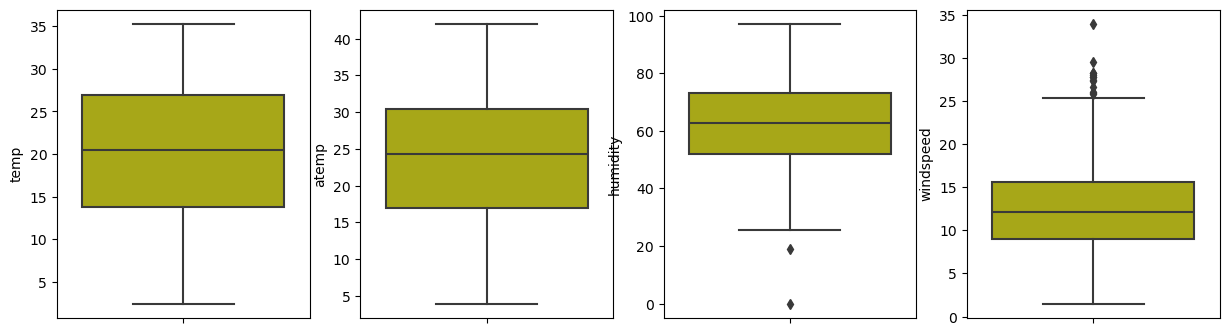

In [653]:
cols = ['temp', 'atemp', 'humidity', 'windspeed']
plt.figure(figsize=(15,4))

plot_number = 1
for col in cols:
    plt.subplot(1,4,plot_number)
    sns.boxplot(y=col, data=bike_sharing_df, color='y')
    plot_number+=1

In [654]:
## no outliers identified for the continous non unique columns

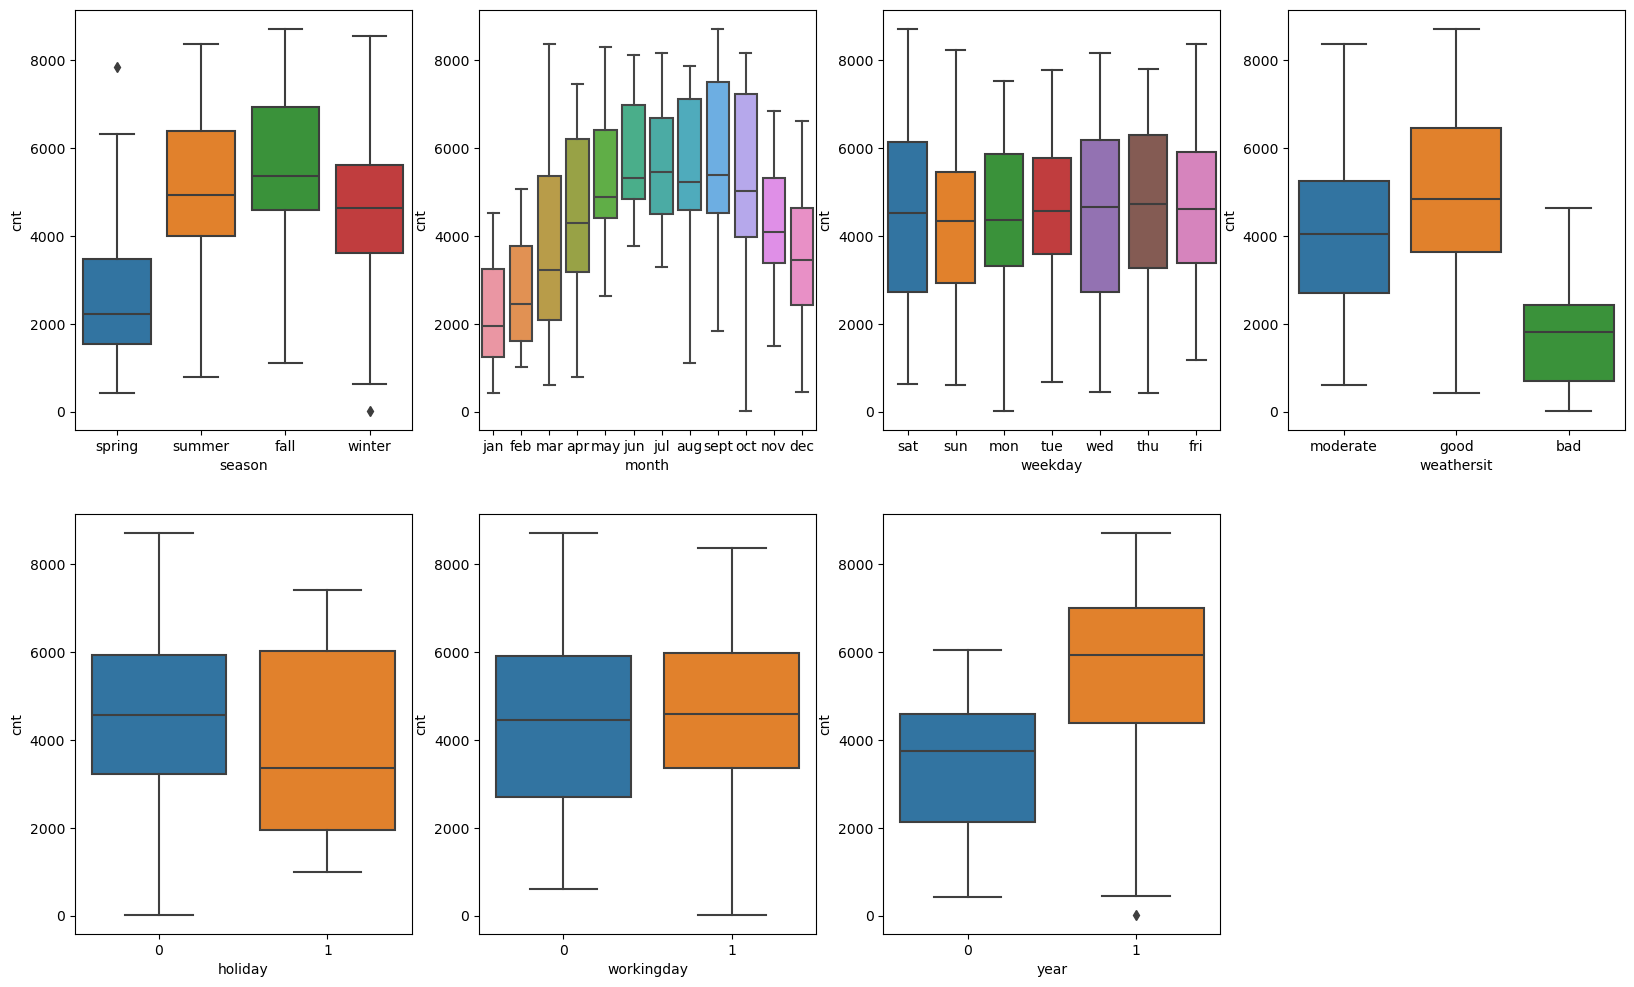

In [655]:
plt.figure(figsize=(20, 12))
plt.subplot(2,4,1)
sns.boxplot(x = 'season', y = 'cnt', data = bike_sharing_df)
plt.subplot(2,4,2)
sns.boxplot(x = 'month', y = 'cnt', data = bike_sharing_df)
plt.subplot(2,4,3)
sns.boxplot(x = 'weekday', y = 'cnt', data = bike_sharing_df)
plt.subplot(2,4,4)
sns.boxplot(x = 'weathersit', y = 'cnt', data = bike_sharing_df)
plt.subplot(2,4,5)
sns.boxplot(x = 'holiday', y = 'cnt', data = bike_sharing_df)
plt.subplot(2,4,6)
sns.boxplot(x = 'workingday', y = 'cnt', data = bike_sharing_df)
plt.subplot(2,4,7)
sns.boxplot(x = 'year', y = 'cnt', data = bike_sharing_df)
plt.show()

In [656]:
# From the above view workingday is not going to be major factor for our analysis

## Step 3: Data Analaysis for Linear Regression

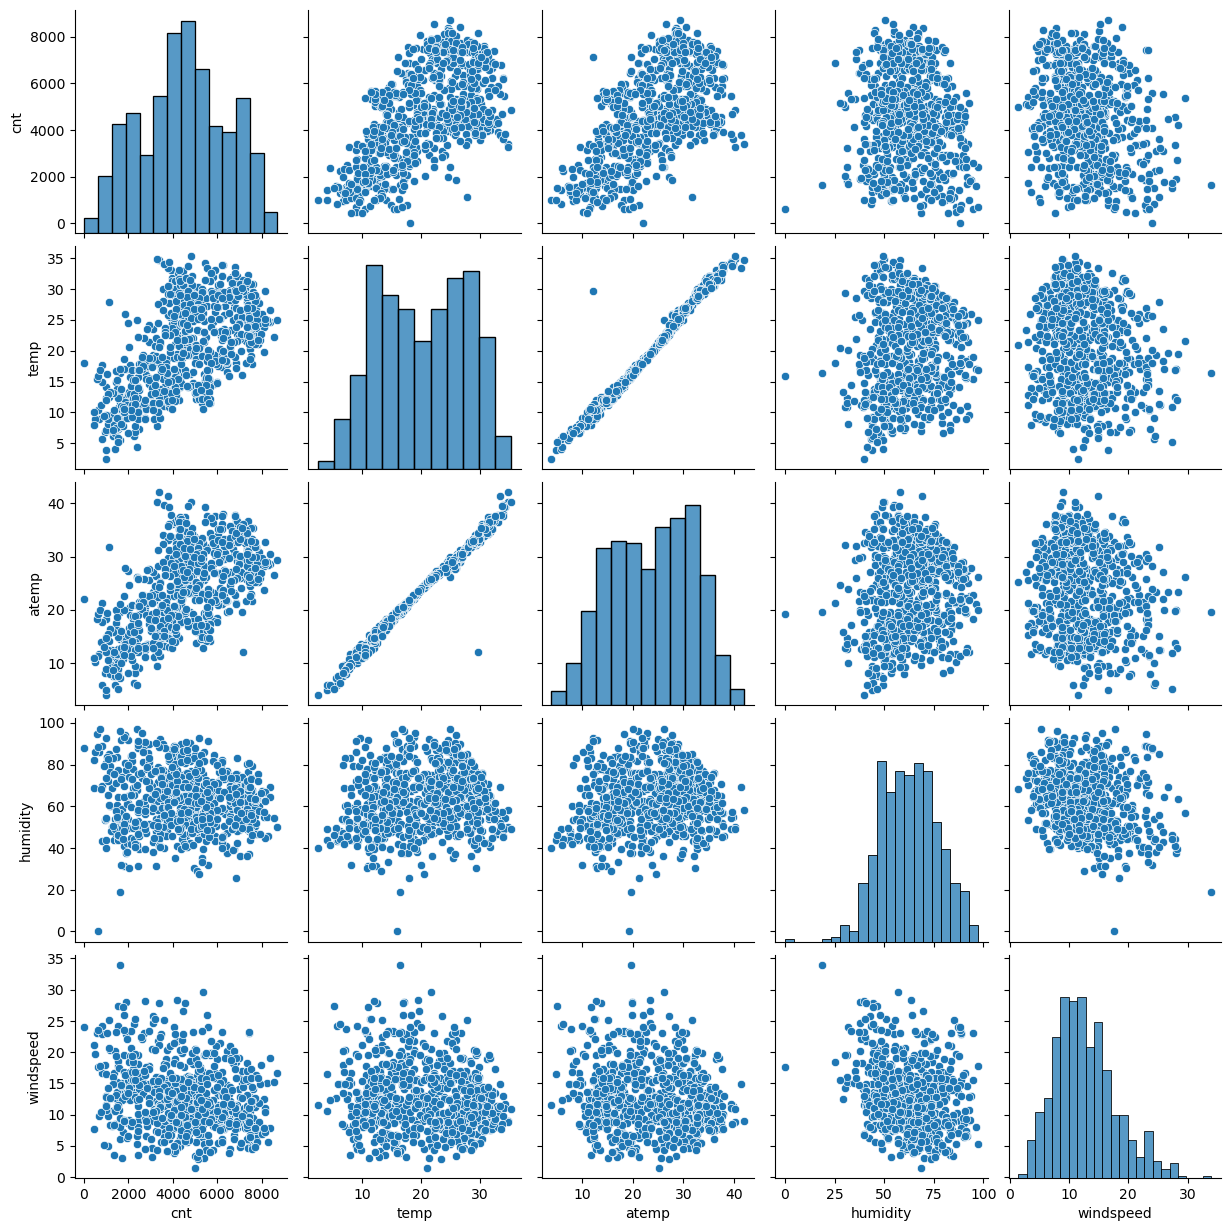

In [657]:
# pair plots for numberical columns
sns.pairplot(data=bike_sharing_df,vars=['cnt','temp','atemp','humidity','windspeed'])
plt.show()

- From the above plots it clearly shows that temp and atemp has linear relationship

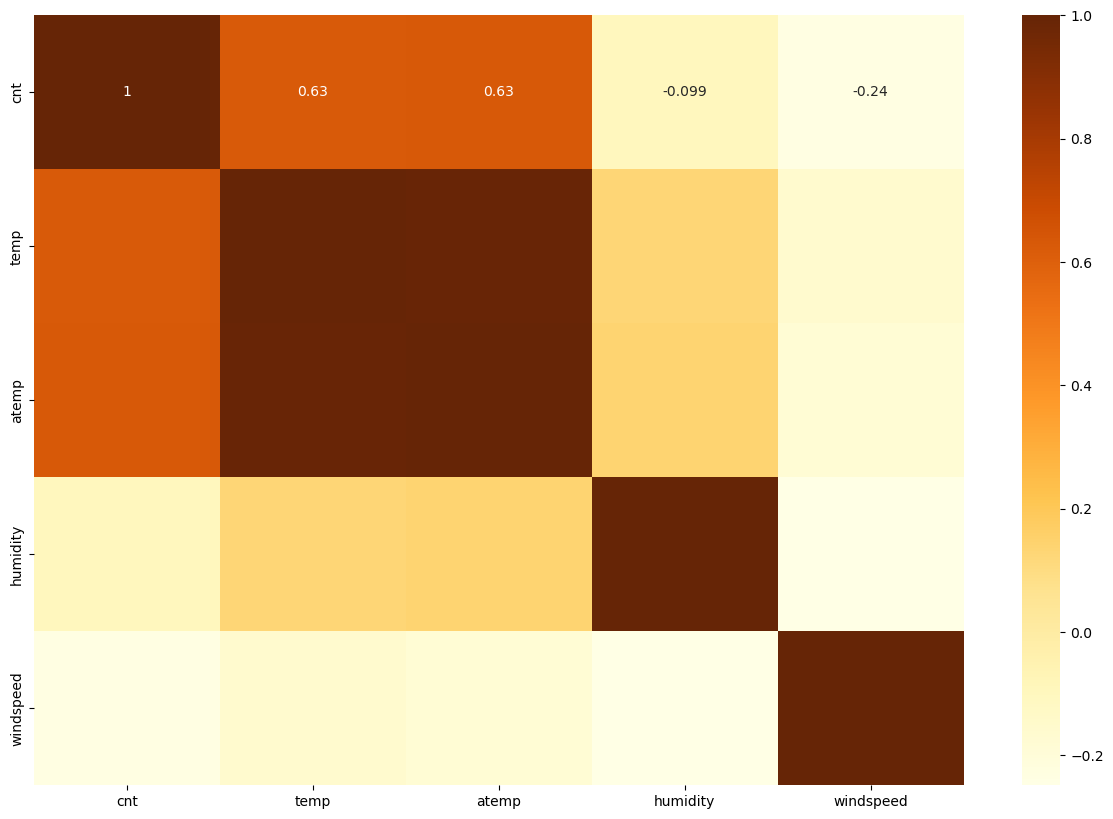

In [658]:
plt.figure(figsize=(15,10))
sns.heatmap(bike_sharing_df[['cnt','temp','atemp','humidity','windspeed']].corr(),cmap="YlOrBr",annot=True)
plt.show()

## Step 4: Data Preparation for Linear Regression

In [659]:
months_df=pd.get_dummies(bike_sharing_df.month,drop_first=True)
weekdays_df=pd.get_dummies(bike_sharing_df.weekday,drop_first=True)
weathersit_df=pd.get_dummies(bike_sharing_df.weathersit,drop_first=True)
seasons_df=pd.get_dummies(bike_sharing_df.season,drop_first=True)

In [660]:
bike_sharing_df = pd.concat([bike_sharing_df,months_df,weekdays_df,weathersit_df,seasons_df],axis=1)

In [661]:
# ## dropping the unncessary columns
# bike_sharing_df = pd.get_dummies(data=bike_sharing_df,columns=["season","month","weekday"],drop_first=True)
# bike_sharing_df = pd.get_dummies(data=bike_sharing_df,columns=["weathersit"])

In [662]:
bike_sharing_df=bike_sharing_df.replace({True:1, False:0})

In [663]:
bike_sharing_df.drop(['season','month','weekday','weathersit'], axis = 1, inplace = True)

In [664]:
bike_sharing_df.head()

,year,holiday,workingday,temp,atemp,humidity,windspeed,cnt,aug,dec,...,sat,sun,thu,tue,wed,good,moderate,spring,summer,winter
0,0,0,0,14.110847,18.18125,80.5833,10.749882,985,0,0,...,1,0,0,0,0,0,1,1,0,0
1,0,0,0,14.902598,17.68695,69.6087,16.652113,801,0,0,...,0,1,0,0,0,0,1,1,0,0
2,0,0,1,8.050924,9.47025,43.7273,16.636703,1349,0,0,...,0,0,0,0,0,1,0,1,0,0
3,0,0,1,8.200000,10.60610,59.0435,10.739832,1562,0,0,...,0,0,0,1,0,1,0,1,0,0
4,0,0,1,9.305237,11.46350,43.6957,12.522300,1600,0,0,...,0,0,0,0,1,1,0,1,0,0


### Train and Test data preparation

In [665]:
# initialize the y to target variable
y=bike_sharing_df.pop('cnt')
X=bike_sharing_df

#Train Test split with 70:30 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=100)

In [666]:
X_train.shape

(510, 29)

In [667]:
X_test.shape

(220, 29)

In [668]:
# use continuous numerical variables to scale
numerical_vars = ['temp','atemp','humidity','windspeed']

In [669]:
scaler = MinMaxScaler()

In [670]:
# Fit and transform training set
X_train[numerical_vars] = scaler.fit_transform(X_train[numerical_vars])

In [671]:
X_train.head()

,year,holiday,workingday,temp,atemp,humidity,windspeed,aug,dec,feb,...,sat,sun,thu,tue,wed,good,moderate,spring,summer,winter
576,1,0,1,0.815169,0.766351,0.725633,0.264686,0,0,0,...,0,0,0,1,0,1,0,0,0,0
426,1,0,0,0.442393,0.438975,0.640189,0.255342,0,0,0,...,1,0,0,0,0,0,1,1,0,0
728,1,0,0,0.245101,0.200348,0.498067,0.663106,0,1,0,...,0,1,0,0,0,1,0,1,0,0
482,1,0,0,0.395666,0.391735,0.504508,0.188475,0,0,0,...,1,0,0,0,0,0,1,0,1,0
111,0,0,1,0.345824,0.318819,0.751824,0.380981,0,0,0,...,0,0,0,0,0,0,1,0,1,0


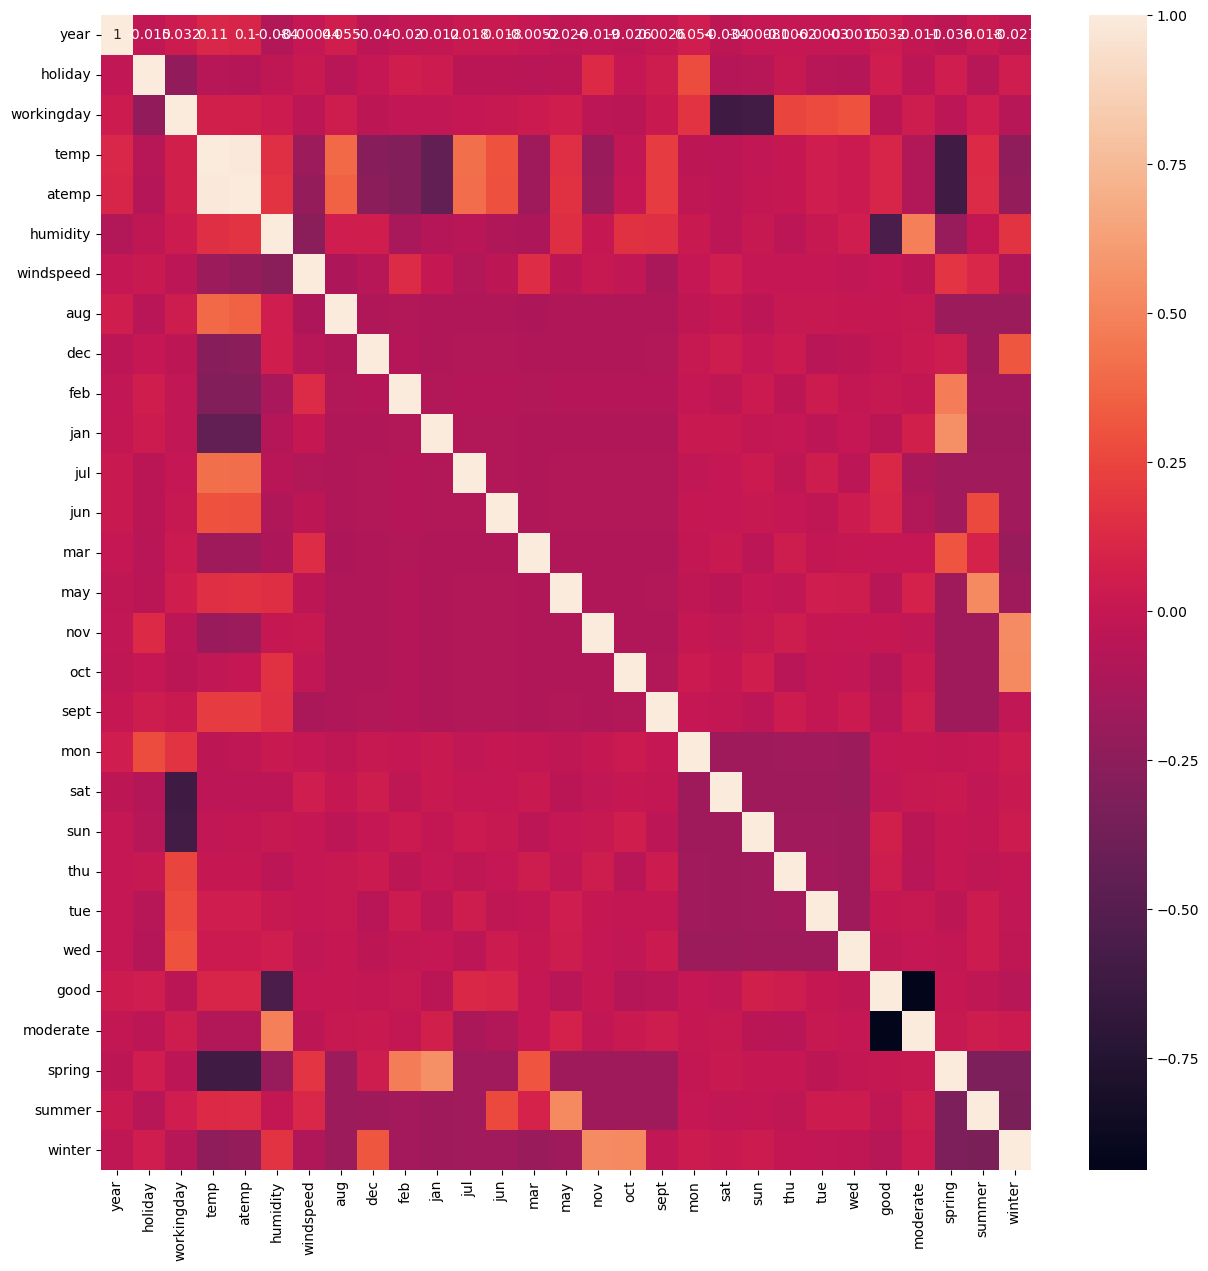

In [672]:
plt.figure(figsize = (15, 15))  
sns.heatmap(X_train.corr(), annot = True)
plt.show()

## Step 5: Build the model

In [673]:

lr = LinearRegression()
lr.fit(X_train,y_train)

LinearRegression()

In [674]:
def build_lr_model(df):
    X_train_sm = sm.add_constant(df)
    lrm = sm.OLS(y_train, X_train_sm).fit()
    print(lrm.summary())
    return lrm

In [675]:
def calculate_vif(df):
    vif = pd.DataFrame()
    vif['Features'] = df.columns
    vif['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    return vif     

In [676]:
#Function to build a model using statsmodel api
def build_model(cols):
    X_train_sm = sm.add_constant(X_train[cols])
    lm = sm.OLS(y_train, X_train_sm).fit()
    print(lm.summary())
    return lm

In [677]:
#Function to calculate VIFs and print them -Takes the columns for which VIF to be calcualted as a parameter
def get_vif(cols):
    df1 = X_train[cols]
    vif = pd.DataFrame()
    vif['Features'] = df1.columns
    vif['VIF'] = [variance_inflation_factor(df1.values, i) for i in range(df1.shape[1])]
    vif['VIF'] = round(vif['VIF'],2)
    print(vif.sort_values(by='VIF',ascending=False))

In [678]:
## Restrict the features to 15 using RFE
rfe = RFE(lr, n_features_to_select=15)

rfe.fit(X_train,y_train)

RFE(estimator=LinearRegression(), n_features_to_select=15)

In [679]:
#List the 15Columns selected by RFE and their weights
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('year', True, 1),
 ('holiday', True, 1),
 ('workingday', True, 1),
 ('temp', True, 1),
 ('atemp', False, 5),
 ('humidity', True, 1),
 ('windspeed', True, 1),
 ('aug', False, 7),
 ('dec', False, 3),
 ('feb', False, 4),
 ('jan', True, 1),
 ('jul', True, 1),
 ('jun', False, 14),
 ('mar', False, 15),
 ('may', False, 6),
 ('nov', False, 2),
 ('oct', False, 13),
 ('sept', True, 1),
 ('mon', False, 9),
 ('sat', True, 1),
 ('sun', False, 8),
 ('thu', False, 11),
 ('tue', False, 10),
 ('wed', False, 12),
 ('good', True, 1),
 ('moderate', True, 1),
 ('spring', True, 1),
 ('summer', True, 1),
 ('winter', True, 1)]

In [680]:
# X_train_rfe = X_train.columns[rfe.support_]
columns = X_train.columns[rfe.support_]
print(columns)

Index(['year', 'holiday', 'workingday', 'temp', 'humidity', 'windspeed', 'jan',
       'jul', 'sept', 'sat', 'good', 'moderate', 'spring', 'summer', 'winter'],
      dtype='object')


In [681]:
bike_sharing_df.head()

,year,holiday,workingday,temp,atemp,humidity,windspeed,aug,dec,feb,...,sat,sun,thu,tue,wed,good,moderate,spring,summer,winter
0,0,0,0,14.110847,18.18125,80.5833,10.749882,0,0,0,...,1,0,0,0,0,0,1,1,0,0
1,0,0,0,14.902598,17.68695,69.6087,16.652113,0,0,0,...,0,1,0,0,0,0,1,1,0,0
2,0,0,1,8.050924,9.47025,43.7273,16.636703,0,0,0,...,0,0,0,0,0,1,0,1,0,0
3,0,0,1,8.200000,10.60610,59.0435,10.739832,0,0,0,...,0,0,0,1,0,1,0,1,0,0
4,0,0,1,9.305237,11.46350,43.6957,12.522300,0,0,0,...,0,0,0,0,1,1,0,1,0,0


In [682]:
# X_train_rfe = X_train[col]
# Taking 15 columns supported by RFE for regression
X_train_rfe = X_train[['year', 'holiday', 'workingday', 'temp', 'humidity', 'windspeed', 'jan',
       'jul', 'sept', 'sat', 'good', 'moderate', 'spring', 'summer', 'winter']]

In [683]:
cols = ['year', 'holiday', 'workingday', 'temp', 'humidity', 'windspeed', 'jan',
       'jul', 'sept', 'sat', 'good', 'moderate', 'spring', 'summer', 'winter']

In [684]:
# build_model(cols)
build_lr_model(X_train_rfe)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     184.0
Date:                Sat, 22 Jun 2024   Prob (F-statistic):          4.22e-191
Time:                        17:53:13   Log-Likelihood:                -4106.1
No. Observations:                 510   AIC:                             8244.
Df Residuals:                     494   BIC:                             8312.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         60.4930    420.238      0.144      0.8

In [685]:
calculate_vif(X_train_rfe)

,Features,VIF
4,humidity,25.63
3,temp,22.84
10,good,14.80
11,moderate,9.07
12,spring,5.69
2,workingday,5.42
5,windspeed,4.69
14,winter,4.12
13,summer,3.21
0,year,2.10


In [686]:
## humidity as Higher VIF, hence dropping this column.
X_train_rfe = X_train_rfe.drop(['humidity'], axis = 1)
build_lr_model(X_train_rfe)
calculate_vif(X_train_rfe)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     189.6
Date:                Sat, 22 Jun 2024   Prob (F-statistic):          1.60e-188
Time:                        17:53:13   Log-Likelihood:                -4115.0
No. Observations:                 510   AIC:                             8260.
Df Residuals:                     495   BIC:                             8324.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -996.0961    341.659     -2.915      0.0

,Features,VIF
9,good,14.79
3,temp,13.96
10,moderate,8.48
2,workingday,5.34
4,windspeed,4.67
11,spring,4.48
12,summer,2.79
13,winter,2.74
0,year,2.08
8,sat,1.99


In [687]:
## good as Higher VIF, hence dropping this column.
X_train_rfe = X_train_rfe.drop(['good'], axis = 1)
build_lr_model(X_train_rfe)
calculate_vif(X_train_rfe)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.797
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                     150.1
Date:                Sat, 22 Jun 2024   Prob (F-statistic):          2.07e-162
Time:                        17:53:14   Log-Likelihood:                -4179.9
No. Observations:                 510   AIC:                             8388.
Df Residuals:                     496   BIC:                             8447.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1458.1514    310.171      4.701      0.0

,Features,VIF
3,temp,7.06
2,workingday,5.22
4,windspeed,4.62
10,spring,3.07
11,summer,2.34
0,year,2.07
8,sat,1.96
12,winter,1.96
5,jan,1.62
6,jul,1.59


In [688]:
## holiday as Higher P value, hence dropping this column.
X_train_rfe = X_train_rfe.drop(['holiday'], axis = 1)
build_lr_model(X_train_rfe)
calculate_vif(X_train_rfe)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.796
Model:                            OLS   Adj. R-squared:                  0.791
Method:                 Least Squares   F-statistic:                     161.9
Date:                Sat, 22 Jun 2024   Prob (F-statistic):          5.27e-163
Time:                        17:53:14   Log-Likelihood:                -4181.2
No. Observations:                 510   AIC:                             8388.
Df Residuals:                     497   BIC:                             8443.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1398.7917    308.245      4.538      0.0

,Features,VIF
2,temp,6.81
1,workingday,4.66
3,windspeed,4.61
9,spring,2.99
10,summer,2.33
0,year,2.07
11,winter,1.90
7,sat,1.83
4,jan,1.62
5,jul,1.59


In [689]:
## Jan  has Higher P value, hence dropping this column.
X_train_rfe = X_train_rfe.drop(['jan'], axis = 1)
build_lr_model(X_train_rfe)
calculate_vif(X_train_rfe)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.791
Method:                 Least Squares   F-statistic:                     175.6
Date:                Sat, 22 Jun 2024   Prob (F-statistic):          1.73e-163
Time:                        17:53:56   Log-Likelihood:                -4182.7
No. Observations:                 510   AIC:                             8389.
Df Residuals:                     498   BIC:                             8440.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1273.9778    300.342      4.242      0.0

,Features,VIF
2,temp,6.72
1,workingday,4.63
3,windspeed,4.59
8,spring,2.38
9,summer,2.32
0,year,2.06
10,winter,1.90
6,sat,1.82
4,jul,1.58
7,moderate,1.54


In [691]:
## Jan  has Higher P value, hence dropping this column.
X_train_rfe = X_train_rfe.drop(['jul'], axis = 1)
build_lr_model(X_train_rfe)
calculate_vif(X_train_rfe)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.793
Model:                            OLS   Adj. R-squared:                  0.788
Method:                 Least Squares   F-statistic:                     190.6
Date:                Sat, 22 Jun 2024   Prob (F-statistic):          2.59e-163
Time:                        17:55:51   Log-Likelihood:                -4185.8
No. Observations:                 510   AIC:                             8394.
Df Residuals:                     499   BIC:                             8440.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1193.5835    300.141      3.977      0.0

,Features,VIF
2,temp,5.47
1,workingday,4.63
3,windspeed,4.58
7,spring,2.29
0,year,2.06
8,summer,2.00
5,sat,1.82
9,winter,1.74
6,moderate,1.54
4,sept,1.22


In [692]:
## spring  has Higher P value, hence dropping this column.
X_train_rfe = X_train_rfe.drop(['spring'], axis = 1)
lrm=build_lr_model(X_train_rfe)
calculate_vif(X_train_rfe)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.791
Model:                            OLS   Adj. R-squared:                  0.787
Method:                 Least Squares   F-statistic:                     210.0
Date:                Sat, 22 Jun 2024   Prob (F-statistic):          1.38e-163
Time:                        17:59:37   Log-Likelihood:                -4188.0
No. Observations:                 510   AIC:                             8396.
Df Residuals:                     500   BIC:                             8438.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        704.9874    182.064      3.872      0.0

,Features,VIF
2,temp,4.76
1,workingday,4.02
3,windspeed,3.40
0,year,2.01
5,sat,1.68
7,summer,1.57
6,moderate,1.50
8,winter,1.38
4,sept,1.20


In [693]:
lrm.params

const          704.987425
year          2075.800350
workingday     416.451488
temp          4792.677551
windspeed    -1597.972910
sept           761.256085
sat            513.762442
moderate      -576.601358
summer         770.262274
winter        1009.241625
dtype: float64

In [695]:
def build_model_sk(X,y):
    lr1 = LinearRegression()
    lr1.fit(X,y)
    return lr1

In [699]:
#Let us build the finalmodel using sklearn
#Build a model with above columns
lr = build_model_sk(X_train[X_train_rfe.columns],y_train)
print(lr.intercept_,lr.coef_)
# X_train_rfe.columns

704.9874253895077 [ 2075.80034965   416.45148769  4792.67755095 -1597.97291005
   761.25608511   513.76244231  -576.60135807   770.262274
  1009.24162513]


In [701]:
y_train_pred = lr.predict(X_train[X_train_rfe.columns])

Text(0.5, 0, 'Errors')

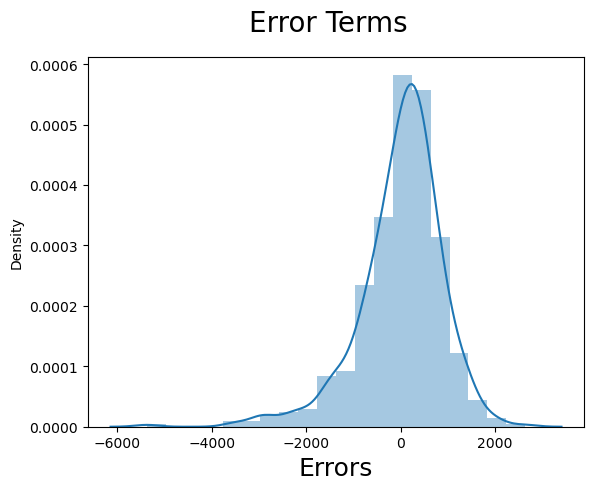

In [702]:
# Plot the histogram of the error terms

fig = plt.figure()
sns.distplot((y_train - y_train_pred), bins = 20)
fig.suptitle('Error Terms', fontsize = 20) 
plt.xlabel('Errors', fontsize = 18)

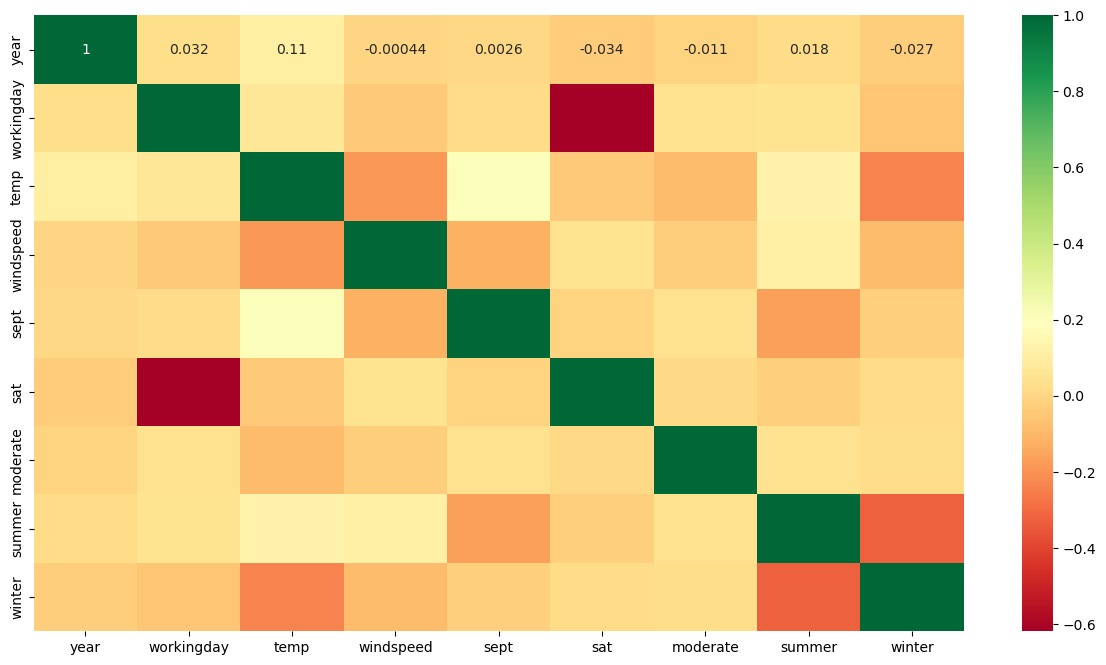

In [703]:
plt.figure(figsize=(15,8))
sns.heatmap(X_train[X_train_rfe.columns].corr(),annot = True, cmap="RdYlGn")
plt.show()

In [704]:
## there is no multi colinearity observed from the above heat map

### Predictions with test data using Final model with trained data

In [705]:
#Scale variables in X_test
num_vars = ['temp','atemp','humidity','windspeed']

#Test data to be transformed only, no fitting
X_test[num_vars] = scaler.transform(X_test[num_vars])

In [713]:
# calculate the R squared value between test and predicted test data sets.
y_pred=y_test_pred
r2=r2_score(y_test,y_test_pred)
print(r2)

0.7692476895188505


In [706]:
y_test_pred = lr.predict(X_test[X_train_rfe.columns])

## Model Evaluation

Text(0, 0.5, 'y_pred')

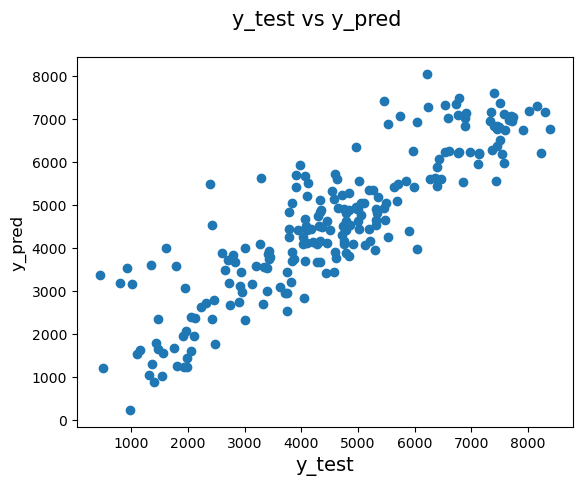

In [710]:
fig = plt.figure()
plt.scatter(y_test, y_pred)
fig.suptitle('y_test vs y_pred', fontsize = 15)             
plt.xlabel('y_test', fontsize = 14)                          
plt.ylabel('y_pred', fontsize = 12) 

In [714]:
adjusted_r2 = round(1-(1-r2)*(X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1),4)
print(adjusted_r2)

0.734


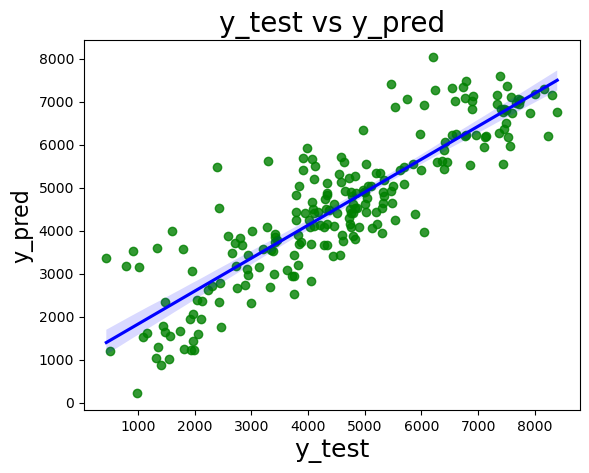

In [720]:
# Visualizing the fit on the test data
# plotting a Regression plot

plt.figure()
sns.regplot(x=y_test, y=y_pred, fit_reg=True,scatter_kws={"color": "green"}, line_kws={"color": "blue"})
plt.title('y_test vs y_pred', fontsize=20)
plt.xlabel('y_test', fontsize=18)
plt.ylabel('y_pred', fontsize=16)
plt.show()

## Comparision of training and test data sets
- Train dataset R^2          : 0.791
- Test dataset R^2           : 0.769
- Train dataset Adjusted R^2 : 0.787    
- Test dataset Adjusted R^2  : 0.734

below variables to predict the demand for shared bikes

- year
- workingday
- temp
- windspeed 
- september month
- saturday
- weathersit mist  
- summer
- winter